# **VGGFace**

this milestone we used a pretrained CNN with out own dataset

In [2]:
#imports
import os
import cv2
import numpy as np
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import keras.utils as image

from PIL import Image
from keras_vggface.vggface import VGGFace
from keras.utils.layer_utils import get_source_inputs
from keras_vggface import utils
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# **Dataset creation**
create a dataset of faces by opening the camera and taking 100 images 

in addition to the a dataset containting 17 diffrent celebrities each with a 100 image at diffrent angles

source:

 https://www.kaggle.com/datasets/vishesh1412/celebrity-face-image-dataset

In [2]:
folder_name = input('\n enter your name ==>  ')
os.makedirs("Dataset/"+folder_name, exist_ok=True)  # Create the folder if it doesn't exist

cam = cv2.VideoCapture(0)  # 0 represents the default camera device
count=0
while(True):
    ret, frame = cam.read()
    #img = cv2.flip(img, -1) # flip video image vertically
    # Waiting for 250 miliseconds between every 2 captures
    k = cv2.waitKey(250) & 0xff
    count += 1
    # Save the captured image into the datasets folder
    image_path = os.path.join("dataset/"+folder_name, f"{count}.jpg")
    cv2.imwrite(image_path, frame)
    # Press 'ESC' for exiting video 
    if k == 27:
        break
    elif count >= 100:
         break
    # Take 100 face samples for training and change the label in the image path to 'test'
    
cam.release()
cv2.destroyAllWindows()

# **Dataset preparation**

Prepare dataset by detecting the faces using haarcascade and saving cropped (224,224) images of just detected faces for model training

In [ ]:
folder_name = 'Dataset'

# dimension of images
image_width = 224
image_height = 224

# for detecting faces
facecascade = cv2.CascadeClassifier('Cascades/haarcascade_frontalface_default.xml')

# set the directory containing the images
images_dir = os.path.join(".", folder_name)

current_id = 0
label_ids = {}

# iterates through all the files in each subdirectories
for root, _, files in os.walk(images_dir):
    for file in files:
        if file.endswith("png") or file.endswith("jpg") or file.endswith("jpeg") :
            # path of the image
            path = os.path.join(root, file)

            # get the label name (name of the person)
            label = os.path.basename(root).replace(" ", ".").lower()

        # add the label (key) and its number (value)
        if not label in label_ids:
            label_ids[label] = current_id
            current_id += 1

        # load the image
        imgtest = cv2.imread(path)
        gray = cv2.cvtColor(imgtest, cv2.COLOR_BGR2GRAY)
        image_array = np.array(imgtest)

        # get the faces detected in the image
        faces =facecascade.detectMultiScale(gray,scaleFactor=1.1, minNeighbors=5)

        # if not exactly 1 face is detected, skip this photo
        if len(faces) != 1:
            print(f'---Photo skipped---\n')
            os.remove(path)
            continue

        # save the detected face(s) and associate
        # them with the label
        for (x_, y_, w, h) in faces:

            # draw the face detected
            face_detect = cv2.rectangle(imgtest,
                    (x_, y_),
                    (x_+w, y_+h),
                    (255, 0, 255), 2)
            # plt.imshow(face_detect,cmap ="gray")
            # plt.show()

            # resize the detected face to 224x224
            size = (image_width, image_height)

            # detected face region
            roi = image_array[y_: y_ + h, x_: x_ + w]

            # resize the detected head to target size
            resized_image = cv2.resize(roi, size)
            image_array = np.array(resized_image, "uint8")

            # remove the original image
            os.remove(path)

            # replace the image with only the face
            im = Image.fromarray(image_array)
            im.save(path)


**The ImageDataGenerator** class applies different transformations to your image to increase feautures of each image 


**Train datagen** creates DirectoryIterator that classifies the folders to indexed classes carrying the name of the folder

In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
'./Dataset',
target_size=(224,224),
color_mode='rgb',
batch_size=32,
class_mode='categorical',
shuffle=True)

train_generator.class_indices.values()
classNumber = len(train_generator.class_indices.values())
print(train_generator.class_indices)

Found 1553 images belonging to 18 classes.


# **Model comparison**

on intialisng the base model, by setting the (include top) to false the connected layer is not included in the network making us able to train the network on our own dataset to retrain the classification weights



![CNN](https://storage.googleapis.com/lds-media/images/vgg16-architecture.width-1200.jpg)

With top the number of layers is **26** while without it is **19**

In [7]:
from keras_vggface.vggface import VGGFace

base_model = VGGFace(include_top=True,
    model='vgg16',
    input_shape=(224, 224, 3))
base_model.summary()

print(len(base_model.layers))


Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [8]:
base_model = VGGFace(include_top=False,
model='vgg16',
input_shape=(224, 224, 3))
base_model.summary()
print(len(base_model.layers))


Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

# **Adding layers**
 
 Adding layers to the base model 
 
 Because the first 19 layers were already trained by the VGGFace16 they are set to non trainable

In [18]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)

# final layer with softmax activation
preds = Dense(classNumber, activation='sigmoid')(x)

# create a new model with the base model's original input and the 
# new model's output
model = Model(inputs = base_model.input, outputs = preds)

# don't train the first 19 layers - 0..18
for layer in model.layers[:19]:
    layer.trainable = False

# train the rest of the layers
for layer in model.layers[19:]:
    layer.trainable = True


# **Training**

In [20]:
model.compile(optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.fit(train_generator,
  batch_size = 1,
  verbose = 1,
  epochs = 10)


Epoch 1/10
49/49 [==============================] - 97s 2s/step - loss: 1.2315 - accuracy: 0.6600
Epoch 2/10
49/49 [==============================] - 97s 2s/step - loss: 0.0801 - accuracy: 0.9813
Epoch 3/10
49/49 [==============================] - 98s 2s/step - loss: 0.0263 - accuracy: 0.9955
Epoch 4/10
49/49 [==============================] - 102s 2s/step - loss: 0.0143 - accuracy: 0.9987
Epoch 5/10
49/49 [==============================] - 109s 2s/step - loss: 0.0090 - accuracy: 0.9981
Epoch 6/10
49/49 [==============================] - 112s 2s/step - loss: 0.0054 - accuracy: 0.9994
Epoch 7/10
49/49 [==============================] - 107s 2s/step - loss: 0.0034 - accuracy: 0.9994
Epoch 8/10
49/49 [==============================] - 112s 2s/step - loss: 0.0021 - accuracy: 1.0000
Epoch 9/10
49/49 [==============================] - 107s 2s/step - loss: 0.0016 - accuracy: 1.0000
Epoch 10/10
49/49 [==============================] - 106s 2s/step - loss: 0.0011 - accuracy: 1.0000


# saving model

https://drive.google.com/file/d/1e5-kIIMfMihRBCapiYDZnat7XqfnExjg/view?usp=sharing

In [22]:
# creates a HDF5 file
model.save('VGG16Face_model.h5')

In [23]:
from tensorflow.keras.models import load_model

model = load_model('VGG16Face_model.h5')


In [24]:
import pickle

class_dictionary = train_generator.class_indices
class_dictionary = {
    value:key for key, value in class_dictionary.items()
}
print(class_dictionary)

{0: 'Angelina Jolie', 1: 'Brad Pitt', 2: 'Denzel Washington', 3: 'Hugh Jackman', 4: 'Jennifer Lawrence', 5: 'Johnny Depp', 6: 'Kate Winslet', 7: 'Leonardo DiCaprio', 8: 'Megan Fox', 9: 'Natalie Portman', 10: 'Nicole Kidman', 11: 'Robert Downey Jr', 12: 'Sandra Bullock', 13: 'Scarlett Johansson', 14: 'Tom Cruise', 15: 'Tom Hanks', 16: 'Will Smith', 17: 'omar barbary'}


In [25]:
# save the class dictionary to pickle
face_label_filename = 'face-labels.pickle'
with open(face_label_filename, 'wb') as f: pickle.dump(class_dictionary, f)


In [27]:
import cv2
import os
import pickle
import numpy as np
import pickle

from PIL import Image
import matplotlib.pyplot as plt
import keras.utils as image
from keras_vggface import utils

# dimension of images
image_width = 224
image_height = 224

# load the training labels
face_label_filename = 'face-labels.pickle'
with open(face_label_filename, "rb") as f: class_dictionary = pickle.load(f)

class_list = [value for _, value in class_dictionary.items()]
print(class_list)


['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith', 'omar barbary']


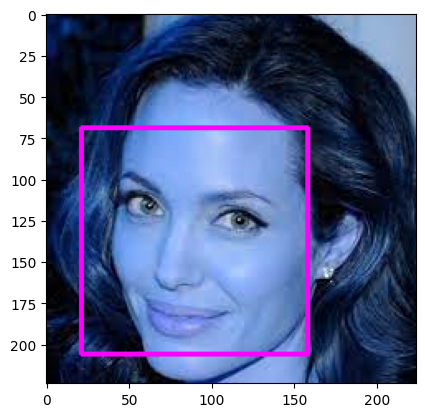

1/1 [==============================] - 0s 121ms/step
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
0
Predicted face: Angelina Jolie



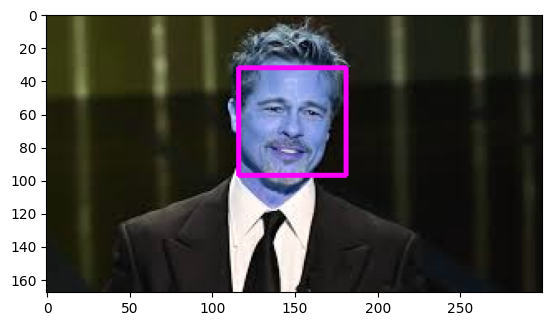

1/1 [==============================] - 0s 107ms/step
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1
Predicted face: Brad Pitt



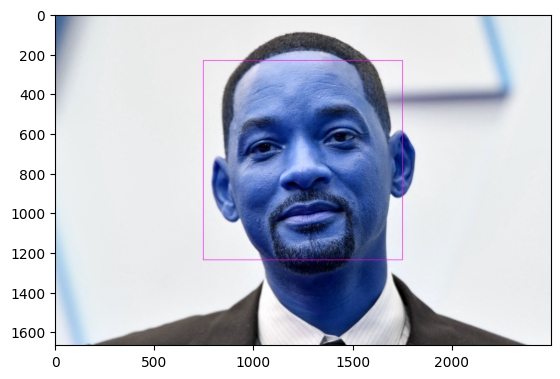

1/1 [==============================] - 0s 112ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
16
Predicted face: Will Smith



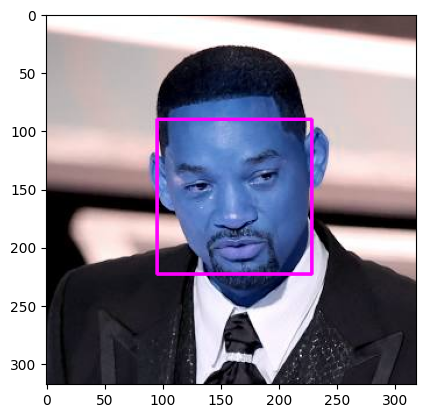

1/1 [==============================] - 0s 127ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
16
Predicted face: Will Smith



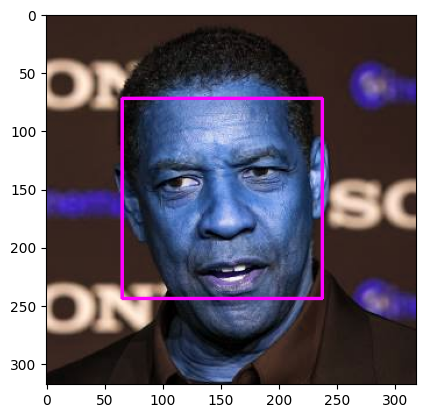

1/1 [==============================] - 0s 101ms/step
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
2
Predicted face: Denzel Washington



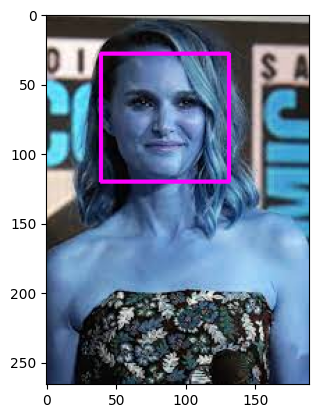

1/1 [==============================] - 0s 107ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
9
Predicted face: Natalie Portman



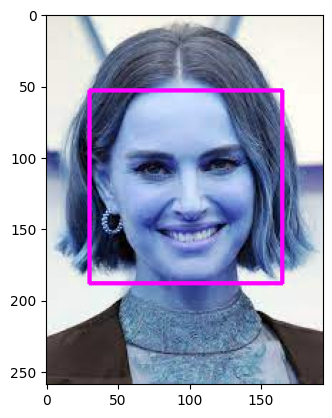

1/1 [==============================] - 0s 112ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
9
Predicted face: Natalie Portman



In [31]:
# for detecting faces
facecascade =  cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

for i in range(1,8): 
    test_image_filename = f'./facetest/{i}.jpg'
    # load the image
    imgtest = cv2.imread(test_image_filename, cv2.IMREAD_COLOR)
    image_array = np.array(imgtest, "uint8")

    # get the faces detected in the image
    faces = facecascade.detectMultiScale(imgtest, 
        scaleFactor=1.1, minNeighbors=5)

    # if not exactly 1 face is detected, skip this photo
    if len(faces) != 1: 
        print(f'---We need exactly 1 face; photo skipped---')
        print()
        continue

    for (x_, y_, w, h) in faces:
        # draw the face detected
        face_detect = cv2.rectangle(
            imgtest, (x_, y_), (x_+w, y_+h), (255, 0, 255), 2)
        plt.imshow(face_detect)
        plt.show()

        # resize the detected face to 224x224
        size = (image_width, image_height)
        roi = image_array[y_: y_ + h, x_: x_ + w]
        resized_image = cv2.resize(roi, size)

        # prepare the image for prediction
        x = image.img_to_array(resized_image)
        x = np.expand_dims(x, axis=0)
        x = utils.preprocess_input(x, version=1)

        # making prediction
        predicted_prob = model.predict(x)
        print(predicted_prob)
        print(predicted_prob[0].argmax())
        print("Predicted face: " + class_list[predicted_prob[0].argmax()])
        print("============================\n")


In [29]:
from PIL import Image
import numpy as np
import cv2
import pickle
from tensorflow.keras.models import load_model

# for face detection
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# resolution of the webcam
screen_width = 1280       # try 640 if code fails
screen_height = 720

# size of the image to predict
image_width = 224
image_height = 224

# load the trained model
model = load_model('transfer_learning_trained_face_cnn_model.h5')

# the labels for the trained model
with open("face-labels.pickle", 'rb') as f:
    og_labels = pickle.load(f)
    labels = {key:value for key,value in og_labels.items()}
    print(labels)

# default webcam
stream = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    (grabbed, frame) = stream.read()
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # try to detect faces in the webcam
    faces = face_cascade.detectMultiScale(
        rgb, scaleFactor=1.3, minNeighbors=5)

    # for each faces found
    for (x, y, w, h) in faces:
        roi_rgb = rgb[y:y+h, x:x+w]
        # Draw a rectangle around the face
        color = (255, 0, 0) # in BGR
        stroke = 2
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, stroke)

        # resize the image
        size = (image_width, image_height)
        resized_image = cv2.resize(roi_rgb, size)
        image_array = np.array(resized_image, "uint8")
        img = image_array.reshape(1,image_width,image_height,3) 
        img = img.astype('float32')
        img /= 255

        # predict the image
        predicted_prob = model.predict(img)

        # Display the label
        font = cv2.FONT_HERSHEY_SIMPLEX
        name = labels[predicted_prob[0].argmax()]
        color = (255, 0, 255)
        stroke = 2
        cv2.putText(frame, f'({name})', (x,y-8),
            font, 1, color, stroke, cv2.LINE_AA)

        # Show the frame
    cv2.imshow("Image", frame)
    k = cv2.waitKey(250) & 0xff
    # Press 'ESC' for exiting video 
    if k == 27:
     break      

# Cleanup
stream.release()
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)

{0: 'Angelina Jolie', 1: 'Brad Pitt', 2: 'Denzel Washington', 3: 'Hugh Jackman', 4: 'Jennifer Lawrence', 5: 'Johnny Depp', 6: 'Kate Winslet', 7: 'Leonardo DiCaprio', 8: 'Megan Fox', 9: 'Natalie Portman', 10: 'Nicole Kidman', 11: 'Robert Downey Jr', 12: 'Sandra Bullock', 13: 'Scarlett Johansson', 14: 'Tom Cruise', 15: 'Tom Hanks', 16: 'Will Smith', 17: 'omar barbary'}
1/1 [==============================] - 0s 100ms/step


-1